<a href="https://colab.research.google.com/github/amineHY/prediction_performance_time_series/blob/master/script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Description du projet

In [0]:
# Ce projet est un POC permettant le forecasting des performances (KPI) des membranes sur des sites traitements des eaux de Véolia (Waste technologie)
# KPI en question est la pression en bar
# la température est fournie en degré celcius

### Import Librairies

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import Series
import warnings
import seaborn as sns
from sklearn.metrics import accuracy_score

# get acces to my google drive account and load the projetc files
from google.colab import drive 
from importlib.machinery import SourceFileLoader
from os.path import join

drive.mount('/content/gdrive')
project_dir = 'gdrive/My Drive/projets_veolia/projet_1_KPI_forecasting/'
utils = SourceFileLoader('utils', join(project_dir, 'utils.py')).load_module()

plt.style.use('ggplot')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Data understading and preparation

In [8]:
file = (project_dir + 'data_kpi_forecasting.csv')
df_orig = pd.read_csv(file)
print('\nTaille de la dataset : {} \n' .format(df_orig.shape) )
print('\nLes colonnes :{}'.format(df_orig.columns))


Taille de la dataset : (7043, 8) 


Les colonnes :Index(['Unnamed: 0', 'train', 'site', 'date', 'feed_flow', 'product_flow',
       'KPI', 'temperature'],
      dtype='object')


In [0]:
df_orig = df_orig.drop(columns='Unnamed: 0', axis=1)
print('\nTete de la dataset:\n {}'.format(df_orig.head()))
print('\nQueue de la dataset:\n {}'.format(df_orig.tail()))


Tete de la dataset:
   train site                 date   feed_flow  product_flow          KPI  \
0     C   M1  2016-01-01 00:00:00         NaN           NaN          NaN   
1     A   S2  2016-01-01 00:24:00  426.182678    203.348166  1988.942858   
2     B   S2  2016-01-01 00:24:00  425.204592    201.783065  2164.238099   
3     A   S2  2016-01-01 04:25:00  426.288330    203.544264  1983.118961   
4     B   S2  2016-01-01 04:25:00  425.881928    202.549126  2164.190066   

   temperature  
0          NaN  
1    17.188713  
2    17.188713  
3    17.643511  
4    17.643511  

Queu de la dataset:
      train site                 date   feed_flow  product_flow          KPI  \
7038     B   M1  2016-12-31 16:02:22  404.951980    198.620636  2378.214789   
7039     B   S2  2016-12-31 20:00:23  423.163367    198.111350  2700.895654   
7040     C   S2  2016-12-31 20:00:23  422.954197    201.134104  2250.791909   
7041     A   M1  2016-12-31 20:02:23  405.135344    201.791153  2333.067080   
70

In [9]:
# extraire le jour, le mois et l'année et les mettre des collonnes séparés
df_orig = utils.extract_datetime(df_orig)
date = df_orig.date
df_orig = df_orig.drop(columns='date', axis=1)
df_orig.head()


,Unnamed: 0,train,site,feed_flow,product_flow,KPI,temperature,year,month,day,Hour,Minute
0,1,C,M1,NaN,NaN,NaN,NaN,2016,1,1,0,0
1,2,A,S2,426.182678,203.348166,1988.942858,17.188713,2016,1,1,0,24
2,3,B,S2,425.204592,201.783065,2164.238099,17.188713,2016,1,1,0,24
3,4,A,S2,426.288330,203.544264,1983.118961,17.643511,2016,1,1,4,25
4,5,B,S2,425.881928,202.549126,2164.190066,17.643511,2016,1,1,4,25


##### 1) Préparation des données pour la prédiction des performances

In [10]:
# Encoder les variables de type 'object' en entier: 
df_orig_enc, dict_enc = utils.encoding_multiple_features(df_orig)
print('Taille de dataset est : {}\n'.format(df_orig_enc.shape))
df_orig_enc.head()

Taille de dataset est : (7043, 12)



,Unnamed: 0,train,site,feed_flow,product_flow,KPI,temperature,year,month,day,Hour,Minute
0,1,2,0,NaN,NaN,NaN,NaN,2016,1,1,0,0
1,2,0,1,426.182678,203.348166,1988.942858,17.188713,2016,1,1,0,24
2,3,1,1,425.204592,201.783065,2164.238099,17.188713,2016,1,1,0,24
3,4,0,1,426.288330,203.544264,1983.118961,17.643511,2016,1,1,4,25
4,5,1,1,425.881928,202.549126,2164.190066,17.643511,2016,1,1,4,25


In [0]:
print('\nNombre de categorie de chaque variable: \n {}\n'.format(df_orig_enc.nunique()))

print('\nNombre des valeurs nulles (NaN) avant imputation: \n {}\n'.format(df_orig_enc.isna().sum()))
df_orig_enc.temperature = df_orig_enc.temperature.fillna(df_orig_enc.temperature.dropna().median())
df_orig_enc.feed_flow = df_orig_enc.feed_flow.fillna(df_orig_enc.feed_flow.dropna().median())
df_orig_enc.product_flow = df_orig_enc.product_flow.fillna(df_orig_enc.product_flow.dropna().median())

print('\nNombre des valeurs nulles (NaN) après imputation par la moyene: \n {}\n'.format(df_orig_enc.isna().sum()))


Nombre de categorie de chaque variable: 
 train              3
site               2
feed_flow       7029
product_flow    7031
KPI             7012
temperature     3988
year               1
month             12
day               31
Hour              24
Minute            60
dtype: int64


Nombre des valeurs nulles (NaN) avant imputation: 
 train             0
site              0
feed_flow        11
product_flow     11
KPI              13
temperature     350
year              0
month             0
day               0
Hour              0
Minute            0
dtype: int64


Nombre des valeurs nulles (NaN) après imputation par la moyene: 
 train            0
site             0
feed_flow        0
product_flow     0
KPI             13
temperature      0
year             0
month            0
day              0
Hour             0
Minute           0
dtype: int64



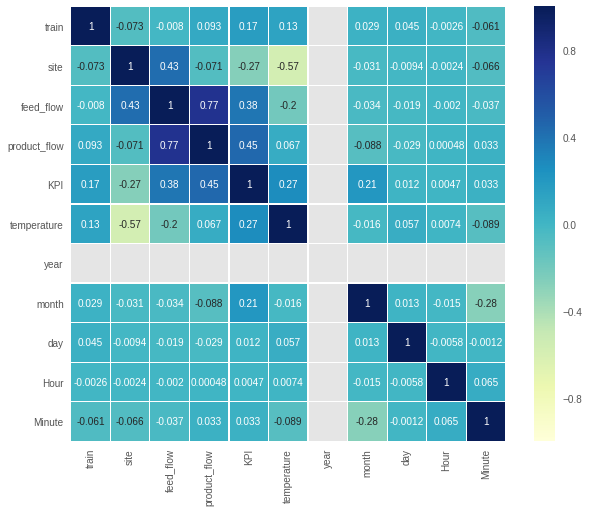

In [0]:
# Affichage de la corrélation entre les variables
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_orig_enc.corr(), annot=True, cmap='YlGnBu', ax=ax, linewidths=0.1, square=True)

In [0]:
print('\nQuelques statistiques de la dataset:\n') 
df_orig_enc.describe()


Quelques statistiques de la dataset:



,train,site,feed_flow,product_flow,KPI,temperature,year,month,day,Hour,Minute
count,7043.000000,7043.000000,7043.000000,7043.000000,7030.000000,7043.000000,7043.0,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.931847,0.563964,412.596504,200.003726,2223.880043,18.193505,2016.0,6.597047,15.869942,10.165412,6.995882
std,0.848616,0.495927,26.075005,12.427282,244.910825,0.748635,0.0,3.402399,8.793465,6.859406,13.780179
min,0.000000,0.000000,100.090207,24.214670,4.645812,16.074722,2016.0,1.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,404.876015,198.470017,2080.827687,17.601891,2016.0,4.000000,8.000000,4.000000,0.000000
50%,1.000000,1.000000,423.227767,202.141936,2248.164364,18.217314,2016.0,7.000000,16.000000,12.000000,0.000000
75%,2.000000,1.000000,425.353139,203.657483,2369.945542,18.706282,2016.0,10.000000,23.000000,16.000000,5.000000
max,2.000000,1.000000,431.125949,225.725827,2965.300798,20.163043,2016.0,12.000000,31.000000,23.000000,59.000000


(None, <matplotlib.legend.Legend at 0x7f63c9a546d8>)

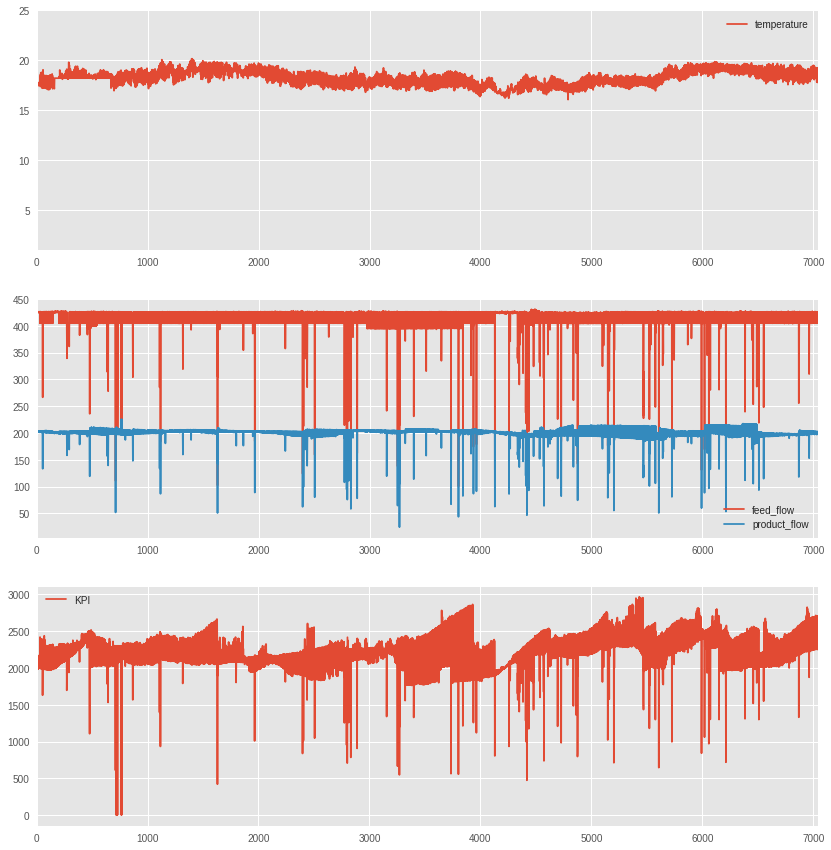

In [0]:
plt.figure(figsize=(14, 15))

plt.subplot(311)
plt.plot(df_orig_enc.temperature, label='temperature'), plt.ylim([1, 25])
plt.autoscale(enable=True, axis='x', tight=True), plt.legend()

plt.subplot(312) 
plt.plot(df_orig_enc.feed_flow, label='feed_flow')
plt.plot(df_orig_enc.product_flow, label='product_flow')
plt.autoscale(enable=True, axis='x', tight=True), plt.legend()

plt.subplot(313) 
plt.plot(df_orig_enc.KPI, label='KPI')
plt.autoscale(enable=True, axis='x', tight=True), plt.legend()

##### 2) Préparation des données pour la prédiction des performances ''journalière''

In [0]:
# Grouper les observations par obtenir des performances journalières
# df_grouped = df_orig.groupby(['year', 'month', 'day', 'train', 'site']).mean()
# df_grouped.to_csv('./data_grouped_and_averaged.csv')
df_grouped = pd.read_csv(project_dir + 'data_grouped_and_averaged.csv')

# performance journalière => drop les heures et faire la moyennes/jour
df_grouped = df_grouped.drop(columns='Hour', axis=1)

# Encoder les variables de type 'object' en entier: 
df_grouped_enc, dict_enc = utils.encoding_multiple_features(df_grouped)
print('Taille de dataset est : {}\n'.format(df_grouped_enc.shape))
df_grouped_enc.head()

Taille de dataset est : (1244, 10)



,year,month,day,train,site,feed_flow,product_flow,KPI,temperature,Minute
0,2016,1,1,0,1,426.120947,203.381329,1986.394590,17.573919,26.5
1,2016,1,1,1,1,425.765404,202.166602,2164.229591,17.573919,26.5
2,2016,1,1,2,0,NaN,NaN,NaN,NaN,0.0
3,2016,1,2,0,1,425.911030,203.164436,1996.452230,17.626515,32.5
4,2016,1,2,1,1,425.206113,201.564024,2158.587059,17.626515,32.5


In [0]:
print('\nNombre de categorie de chaque variable: \n {}\n'.format(df_grouped_enc.nunique()))

print('\nNombre des valeurs nulles (NaN) avant imputation: \n {}\n'.format(df_grouped_enc.isna().sum()))
df_grouped_enc.temperature = df_grouped_enc.temperature.fillna(df_grouped_enc.temperature.dropna().median())
df_grouped_enc.feed_flow = df_grouped_enc.feed_flow.fillna(df_grouped_enc.feed_flow.dropna().median())
df_grouped_enc.product_flow = df_grouped_enc.product_flow.fillna(df_grouped_enc.product_flow.dropna().median())

print('\nNombre des valeurs nulles (NaN) après imputation par la moyene: \n {}\n'.format(df_grouped_enc.isna().sum()))



Nombre de categorie de chaque variable: 
 year               1
month             12
day               31
train              3
site               2
feed_flow       1234
product_flow    1234
KPI             1233
temperature      801
Minute            37
dtype: int64


Nombre des valeurs nulles (NaN) avant imputation: 
 year             0
month            0
day              0
train            0
site             0
feed_flow       10
product_flow    10
KPI             10
temperature     69
Minute           0
dtype: int64


Nombre des valeurs nulles (NaN) après imputation par la moyene: 
 year             0
month            0
day              0
train            0
site             0
feed_flow        0
product_flow     0
KPI             10
temperature      0
Minute           0
dtype: int64



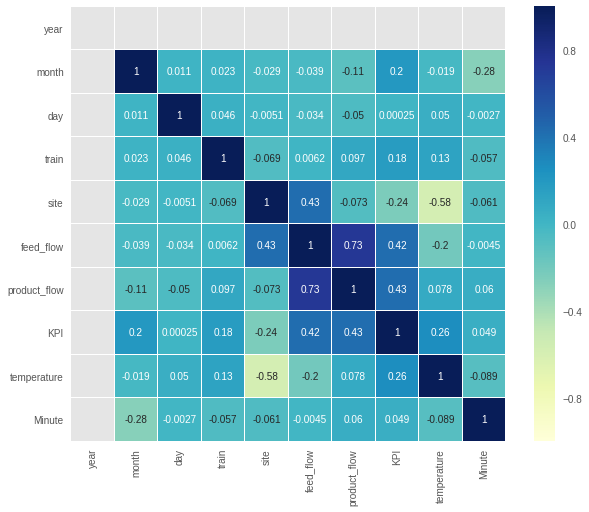

In [0]:
# Affichage de la corrélation entre les variables
corr = df_grouped_enc.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='YlGnBu', ax=ax, linewidths=0.1, square=True, mask=np.zeros_like(corr, dtype=np.bool))

In [0]:
print('\nQuelques statistiques de la dataset:\n') 
df_grouped_enc.describe()


Quelques statistiques de la dataset:



,year,month,day,train,site,feed_flow,product_flow,KPI,temperature,Minute
count,1244.0,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1234.000000,1244.000000,1244.000000
mean,2016.0,6.631029,15.923633,0.930064,0.560289,409.684307,198.732570,2207.165364,18.192488,6.792203
std,0.0,3.395805,8.766009,0.848507,0.496551,26.358598,12.245032,254.107154,0.724690,13.625416
min,2016.0,1.000000,1.000000,0.000000,0.000000,123.918493,62.129087,4.648925,16.474636,0.000000
25%,2016.0,4.000000,8.000000,0.000000,0.000000,404.841089,197.287497,2066.605998,17.603671,0.000000
50%,2016.0,7.000000,16.000000,1.000000,1.000000,415.607105,201.783867,2234.404761,18.234470,0.000000
75%,2016.0,10.000000,23.250000,2.000000,1.000000,425.197771,203.498610,2355.212810,18.649829,2.500000
max,2016.0,12.000000,31.000000,2.000000,1.000000,429.130213,225.211354,2899.135246,19.734752,57.000000


([<matplotlib.lines.Line2D at 0x7f63c98244a8>],
 None,
 <matplotlib.legend.Legend at 0x7f63c9824860>)

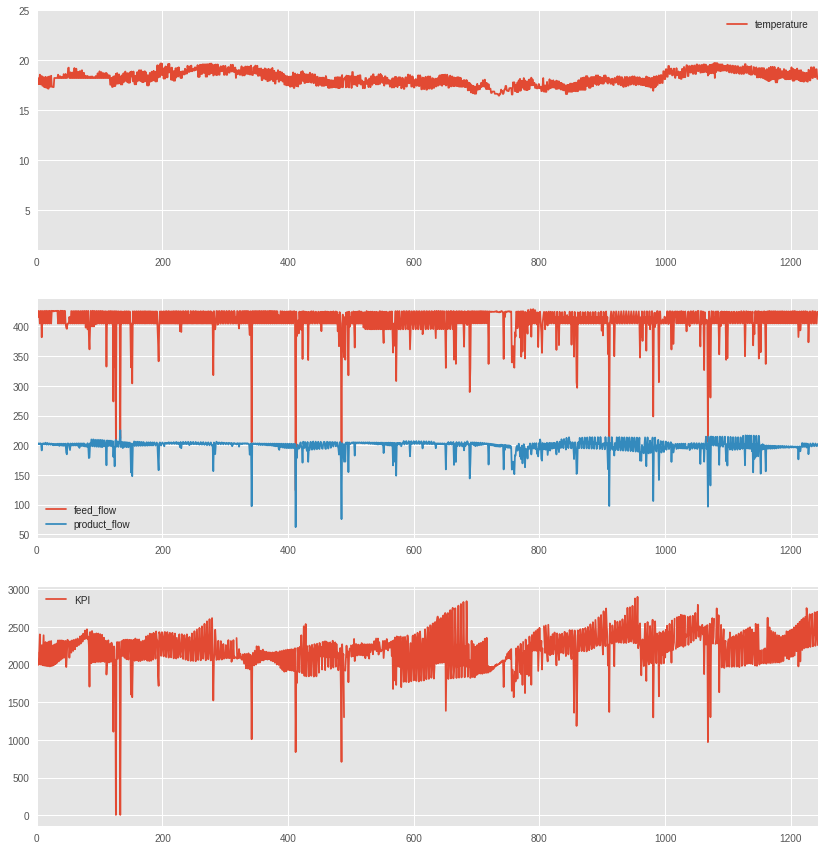

In [0]:
plt.figure(figsize=(14, 15))

plt.subplot(311), 
plt.plot(df_grouped_enc.temperature, label='temperature'), 
plt.ylim([1, 25]), plt.autoscale(enable=True, axis='x', tight=True), plt.legend()

plt.subplot(312), 
plt.plot(df_grouped_enc.feed_flow, label='feed_flow'), 
plt.plot(df_grouped_enc.product_flow, label='product_flow'), 
plt.autoscale(enable=True, axis='x', tight=True), plt.legend()

plt.subplot(313), 
plt.plot(df_grouped_enc.KPI, label='KPI'), plt.autoscale(enable=True, axis='x', tight=True), plt.legend()

## Model: Analyse des Time-series et Machine learning

### 1) Prédiction des performances

#### 1- Prédiction par horaire

Modèles machine learning pour la prédiction

In [0]:
df = df_orig_enc
X = df.loc[:, df.columns != 'KPI']

# la cible a predire
X_test = df.loc[df.KPI.isna(), df.columns != 'KPI']

y = df.KPI.fillna(df.KPI.mean())

print('Taille des features: {}\n'.format(X.shape))
print('Taille de la cible: {}\n'.format(y.shape))

assert X.isna().sum().all()==0, 'y contient des valeurs nulles'
assert y.isna().sum().all()==0, 'y contient des valeurs nulles'


# normalisation des données
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(X, y)
# X = scaler.transform(X)

data_split = utils.split_data(X, y, test_size=.20)
X_train, X_val, y_train, y_val = data_split

y_pred_DT, metric_DT = utils.model_regression(dataset=data_split, modelType='DecisionTree', param=2000)
y_pred_RF, metric_RF = utils.model_regression(dataset=data_split, modelType='RandomForest', param=1000)


print('\n# The mean average error (before tuning param)= {0}'.format(metric_DT['MAE']))
print('\n# The mean average error (before tuning param)= {0}'.format(metric_RF['MAE']))


Taille des features: (7043, 10)

Taille de la cible: (7043,)


# The mean average error (before tuning param)= 23.53312970750386

# The mean average error (before tuning param)= 19.47475414928176


Réglage des paramètres des modèles de prédictions: DecisionTree et RandomForest

In [0]:
# Tune the model by selecting the optimal max_leaf_nodes
candidate_max_leaf_nodes = [1000, 2000, 3000, 3500, 4000, 4500, 5000 ]

scores_DT = {leaf_size: utils.model_regression(dataset=data_split, modelType='DecisionTree', param=leaf_size)[1]['MAE']  for leaf_size in candidate_max_leaf_nodes}
scores_RF = {leaf_size: utils.model_regression(dataset=data_split, modelType='RandomForest', param=leaf_size)[1]['MAE']  for leaf_size in candidate_max_leaf_nodes}

max_leaf_nodes_DT = min(scores_DT, key=scores_DT.get)
max_leaf_nodes_RF = min(scores_RF, key=scores_RF.get)
print('\n# The optimal parameter for max_leaf_nodes is {0} with and MAE= {1:2.2f}'.format(max_leaf_nodes_DT, min(scores_DT.values())))
print('\n# The optimal parameter for max_leaf_nodes is {0} with and MAE= {1:2.2f}'.format(max_leaf_nodes_RF, min(scores_RF.values())))


# The optimal parameter for max_leaf_nodes is 4000 with and MAE= 23.49

# The optimal parameter for max_leaf_nodes is 4000 with and MAE= 18.99


Validation des modèles


# The mean average error (after param tuning)= 0.42

# The mean average error (after param tuning)= 0.93

# The mean average error (after param tuning)= 0.97


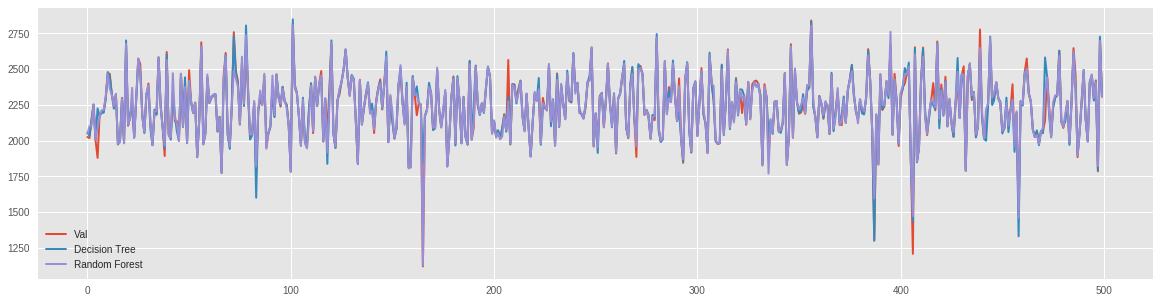

In [0]:
y_pred_LR, metric_LR = utils.model_regression(dataset=data_split, modelType='LinearRegression')
y_pred_DT, metric_DT = utils.model_regression(dataset=data_split, modelType='DecisionTree', param=max_leaf_nodes_DT)
y_pred_RF, metric_RF, model_RF = utils.model_regression(dataset=data_split, modelType='RandomForest', param=max_leaf_nodes_RF, export_model=True)

print('\n# The mean average error (after param tuning)= {0:2.2f}'.format(metric_LR['R_2_score']))
print('\n# The mean average error (after param tuning)= {0:2.2f}'.format(metric_DT['R_2_score']))
print('\n# The mean average error (after param tuning)= {0:2.2f}'.format(metric_RF['R_2_score']))


plt.figure(figsize=(20,5))
plt.plot(y_val.tolist()[0:500], label='Val', linewidth=2)
plt.plot(y_pred_DT[0:500], label='Decision Tree', linewidth=2)
plt.plot(y_pred_RF[0:500], label='Random Forest', linewidth=2)
plt.legend()


Prédiction des KPI

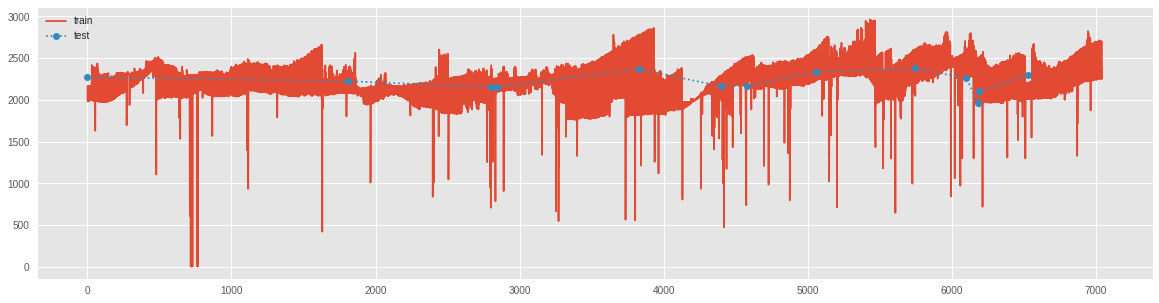

In [0]:
y_pred_test = model_RF.predict(X_test)
df_test = X_test.copy()
df_test['KPI_hat'] = y_pred_test

plt.figure(figsize=(20,5))
plt.plot(df_orig.KPI, label='train')
plt.plot(df_test.KPI_hat, marker='o', ls=':', label='test')
plt.legend()

#### 2- Performances journalières

In [0]:
df_grouped_enc.isna().sum()

year             0
month            0
day              0
train            0
site             0
feed_flow        0
product_flow     0
KPI             10
temperature      0
Minute           0
dtype: int64

In [0]:
df = df_grouped_enc
X = df.loc[:, df.columns != 'KPI']


# la cible à prédire
X_test = df.loc[df.KPI.isna(), df.columns != 'KPI']

y = df.KPI.fillna(df.KPI.mean())

print('Taille des features: {}\n'.format(X.shape))
print('Taille de la cible: {}\n'.format(y.shape))

assert X.isna().sum().all()==0, 'y contient des valeurs nulles'
assert y.isna().sum().all()==0, 'y contient des valeurs nulles'

# Division du dataset en Training et Validation
data_split = utils.split_data(X, y, test_size=.20)
X_train, X_val, y_train, y_val = data_split

y_pred_DT, metric_DT = utils.model_regression(dataset=data_split, modelType='DecisionTree', param=1000)
y_pred_RF, metric_RF = utils.model_regression(dataset=data_split, modelType='RandomForest', param=500)

print('\n# The mean average error (after tuning param)= {0}'.format(metric_DT['MAE']))
print('\n# The mean average error (after tuning param)= {0}'.format(metric_RF['MAE']))

Taille des features: (1244, 9)

Taille de la cible: (1244,)


# The mean average error (after tuning param)= 59.34279602748673

# The mean average error (after tuning param)= 45.35726492393685


In [0]:
# Tune the model by selecting the optimal max_leaf_nodes
candidate_max_leaf_nodes = [400, 450, 500, 550, 600, 610, 630, 650]

scores_DT = {leaf_size: utils.model_regression(dataset=data_split, modelType='DecisionTree', param=leaf_size)[1]['MAE']  for leaf_size in candidate_max_leaf_nodes}
scores_RF = {leaf_size: utils.model_regression(dataset=data_split, modelType='RandomForest', param=leaf_size)[1]['MAE']  for leaf_size in candidate_max_leaf_nodes}

max_leaf_nodes_DT = min(scores_DT, key=scores_DT.get)
max_leaf_nodes_RF = min(scores_RF, key=scores_RF.get)
print('\n# The optimal parameter for max_leaf_nodes is {0} with and MAE= {1:2.2f}'.format(max_leaf_nodes_DT, min(scores_DT.values())))
print('\n# The optimal parameter for max_leaf_nodes is {0} with and MAE= {1:2.2f}'.format(max_leaf_nodes_RF, min(scores_RF.values())))


# The optimal parameter for max_leaf_nodes is 500 with and MAE= 59.10

# The optimal parameter for max_leaf_nodes is 650 with and MAE= 45.34



# The mean average error (after param tuning)= 0.49

# The mean average error (after param tuning)= 0.79

# The mean average error (after param tuning)= 0.90


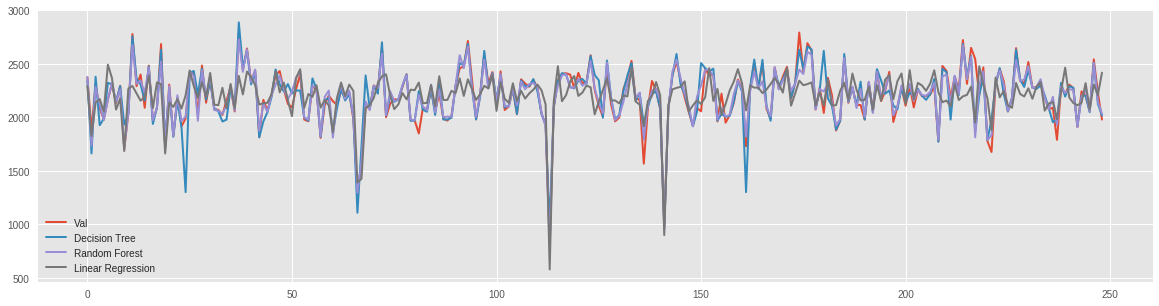

In [0]:
y_pred_LR, metric_LR = utils.model_regression(dataset=data_split, modelType='LinearRegression')
y_pred_DT, metric_DT = utils.model_regression(dataset=data_split, modelType='DecisionTree', param=max_leaf_nodes_DT)
y_pred_RF, metric_RF, model_RF = utils.model_regression(dataset=data_split, modelType='RandomForest', param=max_leaf_nodes_RF, export_model=True)

print('\n# The mean average error (after param tuning)= {0:2.2f}'.format(metric_LR['R_2_score']))
print('\n# The mean average error (after param tuning)= {0:2.2f}'.format(metric_DT['R_2_score']))
print('\n# The mean average error (after param tuning)= {0:2.2f}'.format(metric_RF['R_2_score']))

plt.figure(figsize=(20,5))
plt.plot(y_val.tolist(), label='Val', linewidth=2)
plt.plot(y_pred_DT, label='Decision Tree', linewidth=2)
plt.plot(y_pred_RF, label='Random Forest', linewidth=2)
plt.plot(y_pred_LR, label='Linear Regression', linewidth=2)
plt.legend()


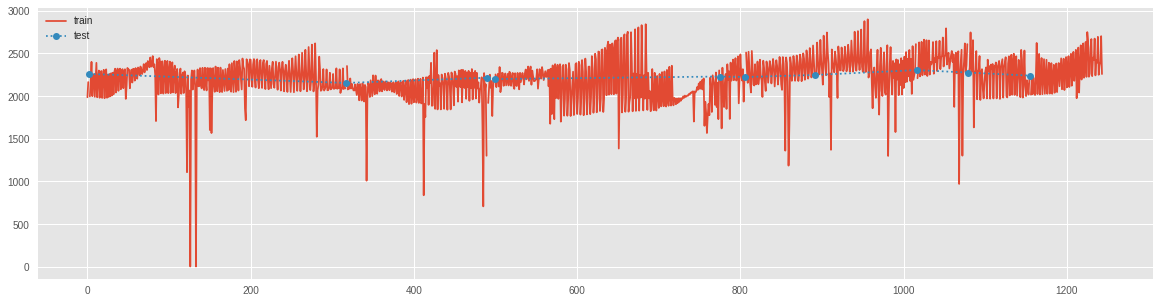

In [0]:
y_pred_test = model_RF.predict(X_test)
df_test = X_test.copy()
df_test['KPI_hat'] = y_pred_test

plt.figure(figsize=(20,5))
plt.plot(df_grouped.KPI, label='train')
plt.plot(df_test.KPI_hat, marker='o', ls=':', label='test')
plt.legend()

### 2) Forecasting des performances: Time series irrégulière

In [0]:
# imputation des valeurs nulles (NaN) de la variable cible (KPI)
df_grouped_enc.KPI = df_grouped_enc.KPI.fillna(df_grouped_enc.KPI.dropna().mean())

# plt.figure(figsize=(14,5))
# plt.plot(df_grouped_enc.KPI, label='KPI'), plt.legend()
df_grouped_enc.columns

Index(['year', 'month', 'day', 'train', 'site', 'feed_flow', 'product_flow',
       'KPI', 'temperature', 'Minute'],
      dtype='object')

In [0]:
# Diviser le dataset en sous dataet: training et validation
X = df_grouped_enc.loc[:,df_grouped_enc.columns != 'KPI']
y = df_grouped_enc.KPI
df_grouped_enc.head()

,year,month,day,train,site,feed_flow,product_flow,KPI,temperature,Minute
0,2016,1,1,0,1,426.120947,203.381329,1986.394590,17.573919,26.5
1,2016,1,1,1,1,425.765404,202.166602,2164.229591,17.573919,26.5
2,2016,1,1,2,0,415.607105,201.783867,2207.165364,18.234470,0.0
3,2016,1,2,0,1,425.911030,203.164436,1996.452230,17.626515,32.5
4,2016,1,2,1,1,425.206113,201.564024,2158.587059,17.626515,32.5


In [0]:
perc = 0.90
idx = np.int((df_grouped_enc.shape[0] * perc))
train = df_grouped_enc[0:idx]
valid = df_grouped_enc[idx:]

In [0]:
# plt.figure(figsize=(15,5))
# plt.plot(train.KPI, label='train')
# plt.plot(valid.KPI, label='valid ({0:2.0f}%)'.format(100-perc*100))
# plt.legend(), plt.autoscale(tight=True)

In [0]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm

# train.index = pd.to_datetime(train.day, format='%Y-%m-%d %H:%M')

#  Naive estimator
y_hat = valid.copy()
y_hat['naive'] = train.KPI.iloc[-1]
from sklearn.metrics import mean_squared_error

RMSE_naive = np.sqrt(mean_squared_error(valid.KPI, y_hat.naive))
print('RMSE = {0:2.2f}'.format(RMSE_naive))

# Simple Moving Average (MA)
y_hat['MA'] = train['KPI'].rolling(15).mean().iloc[-1]

RMSE_MA = np.sqrt(mean_squared_error(valid.KPI, y_hat.MA))
print('RMSE = {0:2.2f}'.format(RMSE_MA))

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


ImportError: ignored

In [0]:
# Simple Exponential Smoothing (SES)
model_SES = SimpleExpSmoothing(np.asarray(train.KPI)).fit(smoothing_level=0.0060, optimized=False)
y_hat['SES'] = model_SES.forecast(len(valid))

RMSE_SES = np.sqrt(mean_squared_error(valid.KPI, y_hat.SES))
print('RMSE = {0:2.2f}'.format(RMSE_SES))

# Holt's Linear Trend Model
# plt.style.use('default')
# plt.figure(figsize=(20, 15))
# sm.tsa.seasonal_decompose(train.KPI).plot()
# result = sm.tsa.stattools.adfuller(train.KPI)
# plt.show()

# y_hat_holt = valid.copy()
# fit1 = Holt(np.asarray(train.KPI)).fit(smoothing_level=0.3, smoothing_slope=0.1)
# y_hat_holt['Holt_linear'] = fit1.forecast(len(valid))

In [0]:
df_grouped.shape

In [0]:
plt.figure(figsize=(15, 5))
plt.plot(train.index, train.KPI, label='Train')
plt.plot(valid.index, valid.KPI, label='Validation')
plt.plot(y_hat.index, y_hat['naive'],  label='Naive ({0:2.2f})'.format(RMSE_naive))
plt.plot(y_hat.index, y_hat['MA'],  label='MA ({0:2.2f})'.format(RMSE_MA))
plt.plot(y_hat.index, y_hat['SES'],  label='SES ({0:2.2f})'.format(RMSE_SES))
plt.legend(loc='best'), plt.autoscale(tight=True)
plt.title('Naive Forecast')

In [0]:
# sm.tsa.seasonal_decompose(np.asarray(train.KPI))

#### Recurrent Neural Network: LSTM

## Extraction des times series pour chaque capteur

In [0]:
df_orig = pd.read_csv("data_kpi_forecasting.csv")
df_orig = utils.extract_datetime(df_orig)
date = df_orig.date
df_orig = df_orig.drop(columns=['Unnamed: 0', 'date'], axis=1)
df_orig.head()


In [0]:
TS_M1_A = df_orig.loc[(df_orig['site']=='M1') & (df_orig['train']=='A'), :]
TS_M1_B = df_orig.loc[(df_orig['site']=='M1') & (df_orig['train']=='B'), :]
TS_M1_C = df_orig.loc[(df_orig['site']=='M1') & (df_orig['train']=='C'), :]
TS_S2_A = df_orig.loc[(df_orig['site']=='S2') & (df_orig['train']=='A'), :]
TS_S2_B = df_orig.loc[(df_orig['site']=='S2') & (df_orig['train']=='B'), :]
TS_S2_C = df_orig.loc[(df_orig['site']=='S2') & (df_orig['train']=='C'), :]
TS = [TS_M1_A, TS_M1_B, TS_M1_C, TS_S2_A, TS_S2_B, TS_S2_C]
df_orig.shape
TS_capteur.site.iloc[0]

In [0]:
plt.figure(figsize=(15,20))
i=1
for TS_capteur in TS: 
    print(TS_capteur.KPI.shape)
    plt.subplot(6,1,i)
    plt.plot(TS_capteur.KPI, '.')
    plt.title('KPI : site '+TS_capteur.site.iloc[0] +' - train '+ TS_capteur.train.iloc[0])
    i+=1
plt.subplots_adjust(wspace=.2, hspace=.5)

In [0]:
plt.figure(figsize=(20,20))
i=1
for TS_capteur in TS: 
    plt.subplot(6,1,i)
    plt.plot( TS_capteur.feed_flow, '.', label='feed_flow')
    plt.plot( TS_capteur.product_flow, 'g.', label='product_flow')
    plt.title('Flux d"entrée et de sortie : site '+TS_capteur.site.iloc[0] +' - train '+ TS_capteur.train.iloc[0])
    plt.legend()
    i+=1
plt.subplots_adjust(wspace=.2, hspace=.5)

### Evaluation

### Prediction